In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
from scipy import stats
from pymc3.distributions import Interpolated
from pymc3 import Model, Normal, Slice, sample
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.4
Running on ArviZ v0.11.4


In [3]:
# model specification
k = 2
T = 20
expectation_mu1 = 0.6
expectation_mu2 = 0.5
N_0 = 10
sd = 0.1
prior_1 = pm.Normal.dist(expectation_mu1,sd)
prior_2 = pm.Normal.dist(expectation_mu2,sd)
mu1_real = prior_1.random()
mu2_real = prior_2.random()
bandit1_real = pm.Normal.dist(mu1_real,sd)
bandit2_real = pm.Normal.dist(mu2_real,sd)
#init sampling
history1 = bandit1_real.random(size=N_0)
history2 = []
print(mu1_real,mu2_real)

0.5540501410049494 0.3901165281618615


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
Got error No model on context stack. trying to find log_likelihood in translation.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
Got error No model on context stack. trying to find log_likelihood in translatio

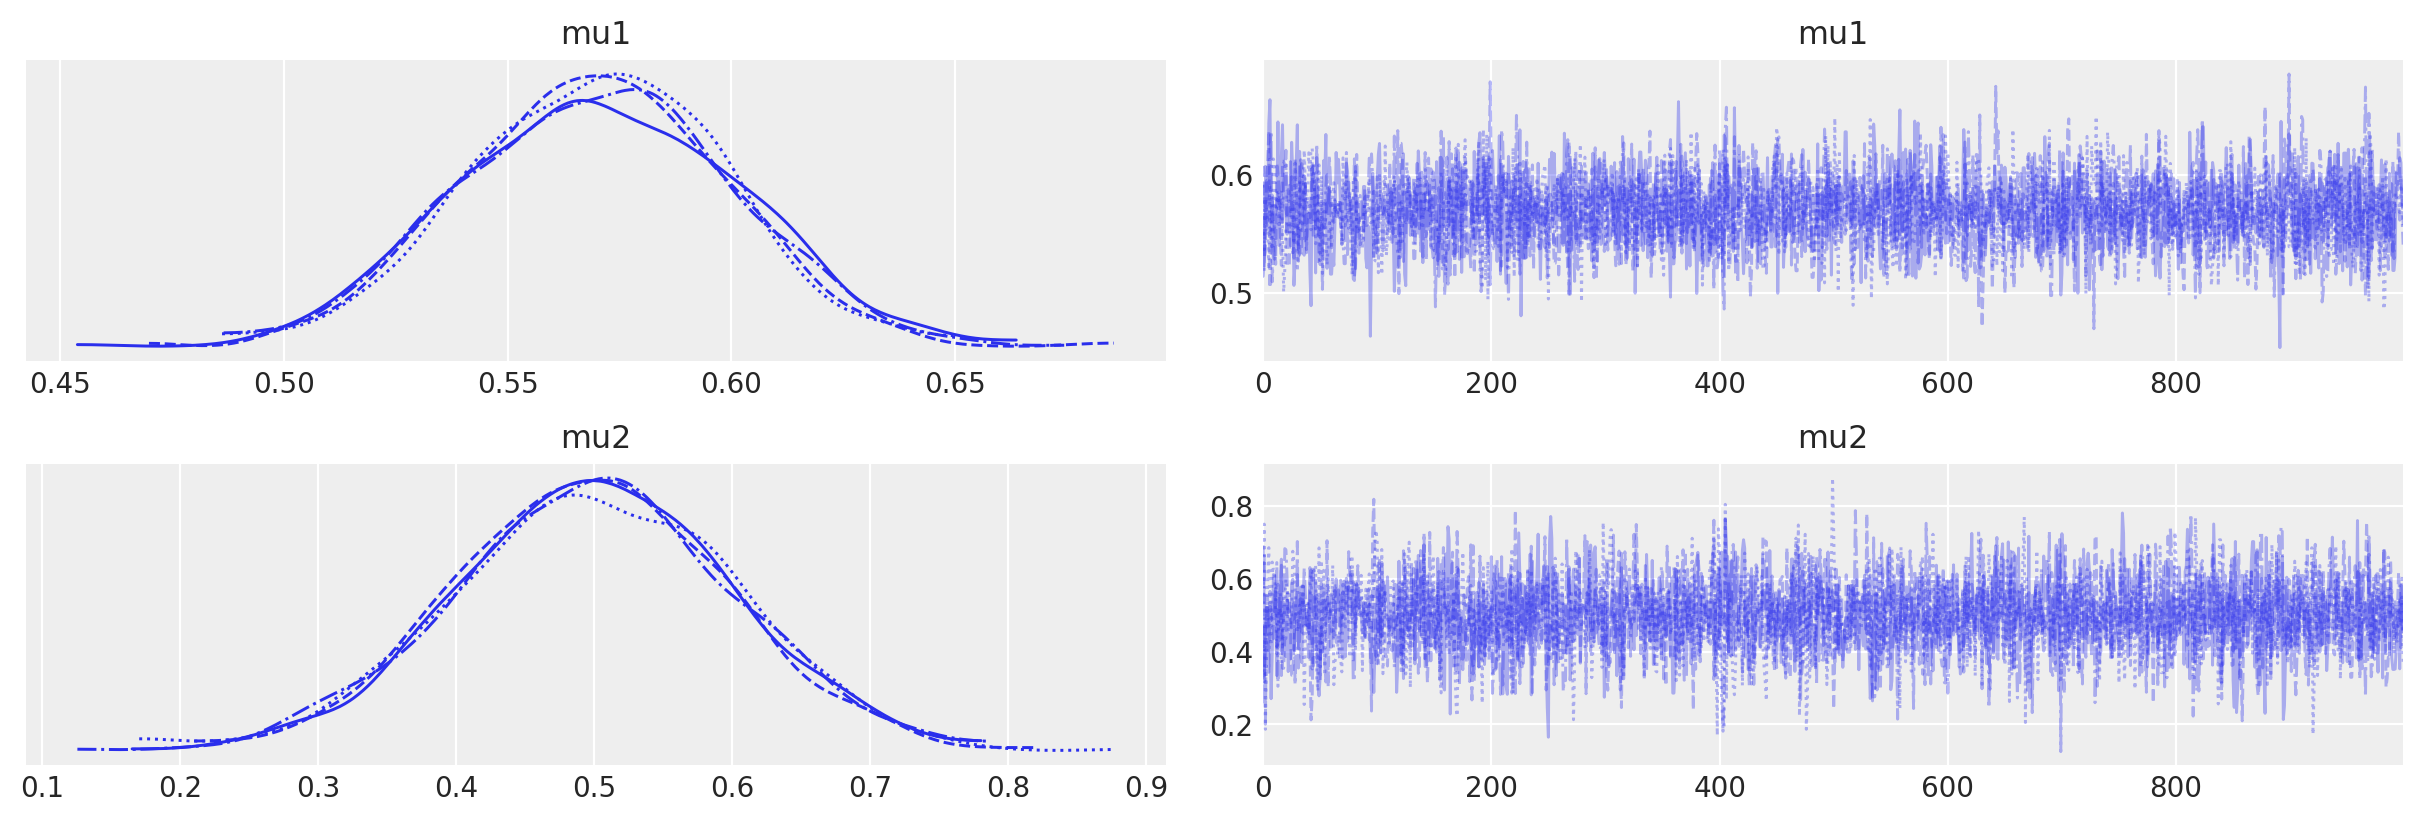

In [4]:
basic_model = pm.Model()
with basic_model:

    # Priors for unknown model parameters
    mu1 = pm.Normal("mu1", mu=expectation_mu1, sigma=sd)
    mu2 = pm.Normal("mu2", mu=expectation_mu2, sigma=sd)

    bandit1 = pm.Normal("bandit1",mu=mu1,sigma=sd,observed= history1)
    bandit2 = pm.Normal("bandit2",mu=mu2,sigma=sd,observed= history2)

    # draw 1000 posterior samples
    trace = pm.sample(1000)
az.plot_trace(trace);

In [5]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [6]:
traces = [trace]
compute_epsilon =  lambda x : max(x/3 - 0.001,0)
exp_g = np.mean(trace["mu1"]) - np.mean(trace["mu2"])
epsilon = compute_epsilon(exp_g)
for i in range(N_0,T):
        
    if np.random.uniform() < epsilon:

        history2 = np.append(history2,bandit2_real.random())

    else:
        
        history1 = np.append(history1,bandit1_real.random()) 





    with pm.Model() as model:

        mu1 = from_posterior("mu1", trace["mu1"])
        mu2 = from_posterior("mu2", trace["mu2"])

        bandit2 = pm.Normal("bandit2",mu=mu2,sigma=sd,observed= history2)


        trace = sample(1000)
        traces.append(trace)
        exp_g = np.mean(trace["mu1"]) - np.mean(trace["mu2"])

        epsilon = compute_epsilon(exp_g)



# # generate data
# np.random.seed(3)


# num_trials = 100000

# mu1_true = np.random.normal(loc=expectation_mu1,scale = sd)
# mu2_true = np.random.normal(loc=expectation_mu2,scale = sd)
# history1 = np.random.normal(mu1_true,sd,num_trials)
# history2 = np.random.normal(mu2_true,sd,num_trials)


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.9523796622443917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.944413080837461, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Tens

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9331157578851526, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8934818948354519, but should be close to 0.8. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9614988939393135, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt):

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.6103956786284388, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5853252866428531, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.6356894747092765, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4606086209540134, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813654133312243, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.5734347442690553, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9382324046706275, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
WARNING (theano.tensor.opt): Cannot

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.9206784165912638, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5557535785988573, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt):

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.6923915795113196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4261642302320331, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3475807468811463, but should be close to 0.8. Try to increase the number of tuni

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.9350225256432149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9314662831210053, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9346011521039114, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
W

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
The acceptance probability does not match the target. It is 0.5302064574818749, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6754081310775529, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43338808382359273, but should be close to 0.8. Try to increase the number of tuni

Got error No model on context stack. trying to find log_likelihood in translation.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
Got error No model on context stack. trying to find log_likelihood in translation.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


array([[<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'mu2'}>]], dtype=object)

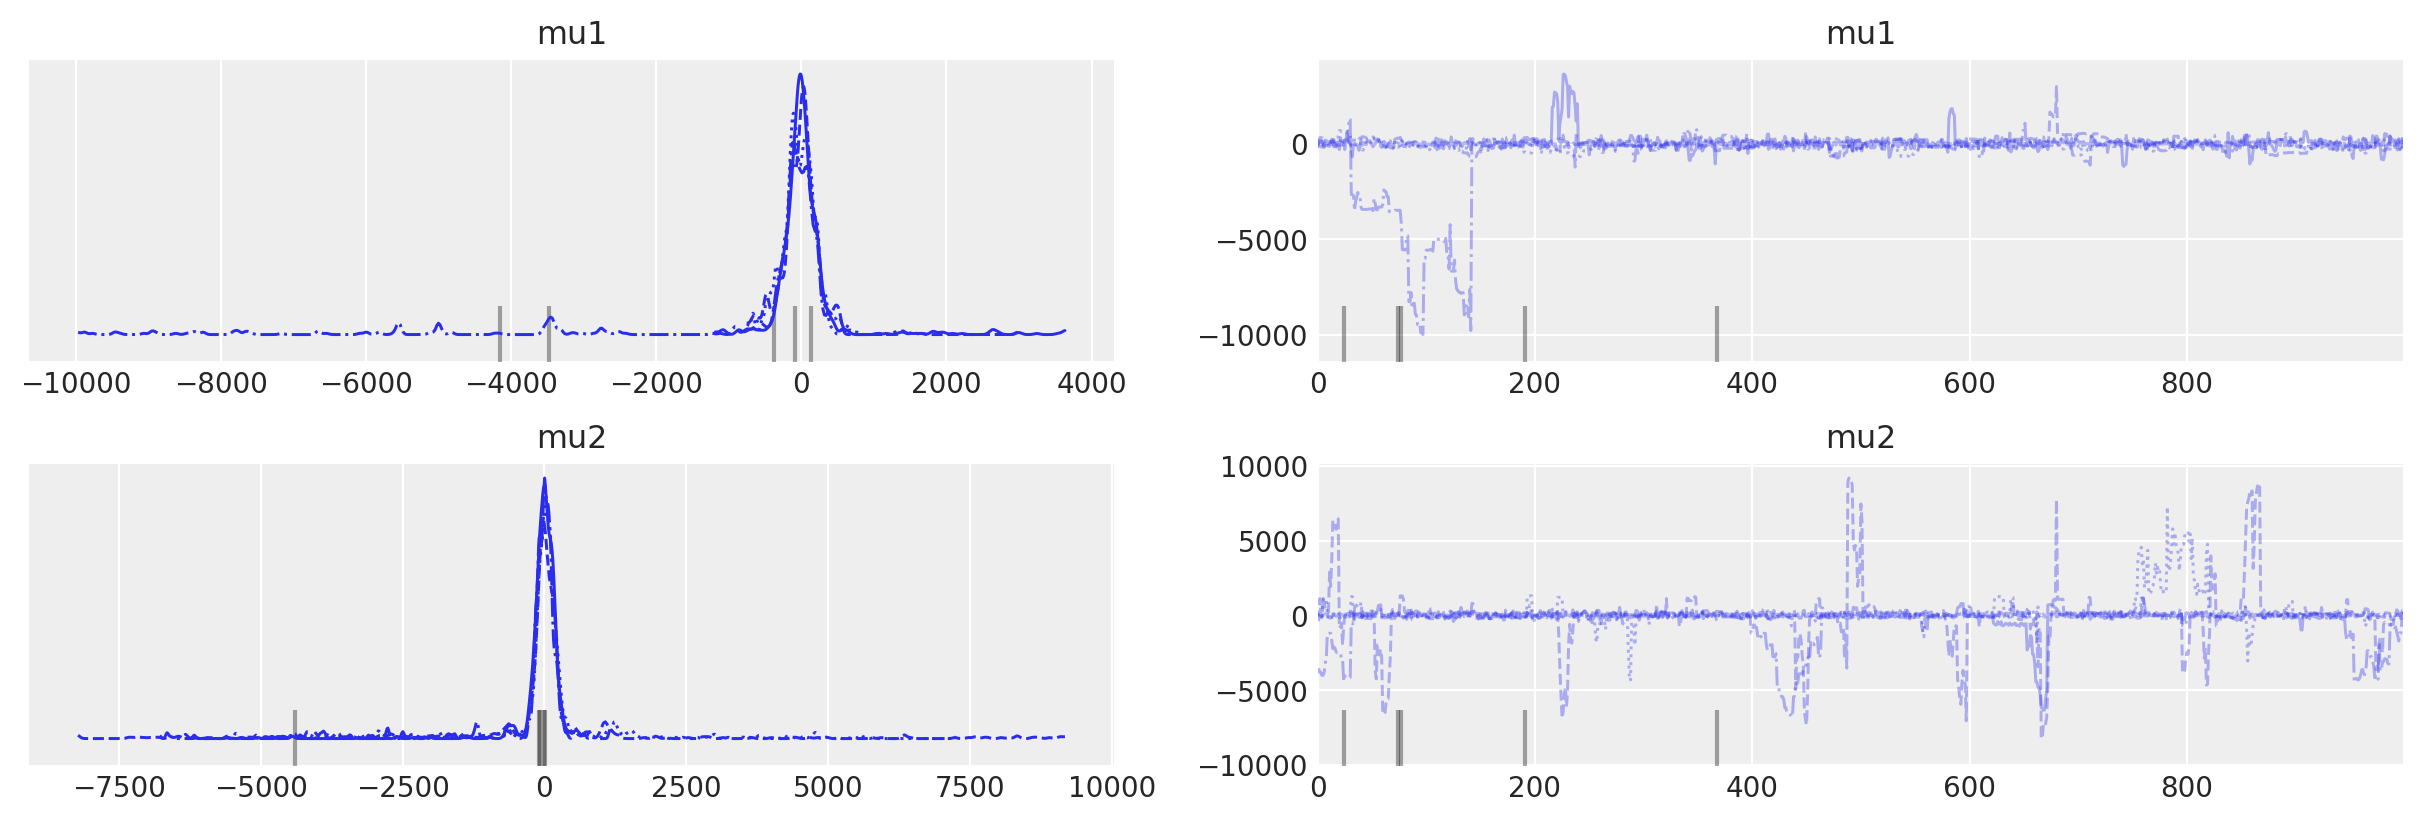

In [13]:
az.plot_trace(trace)

# print(len(traces))
# import matplotlib as mpl
# print("Posterior distributions after " + str(len(traces)) + " iterations.")
# cmap = mpl.cm.autumn
# for param in ["mu1", "mu2"]:
#     plt.figure(figsize=(8, 2))
#     for update_i, trace in enumerate(traces):
#         samples = trace[param]
#         smin, smax = np.min(samples), np.max(samples)
#         x = np.linspace(smin, smax, 100)
#         y = stats.gaussian_kde(samples)(x)
#         plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
#     plt.axvline({"mu1": mu1_real, "mu2": mu2_real}[param], c="k")
#     plt.ylabel("Frequency")
#     plt.title(param)

# plt.tight_layout();

In [14]:
model.logp({"mu1": 0})

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


TypeError: Missing required input: mu1_interval__ ~ TransformedDistribution